In [ ]:
!apt-get install -y python3-tk

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-tk is already the newest version (3.10.8-1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.


In [ ]:
!pip install pyqt5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 19.1 MB/s eta 0:00:00


In [ ]:
!pip install pandas numpy scikit-learn matplotlib

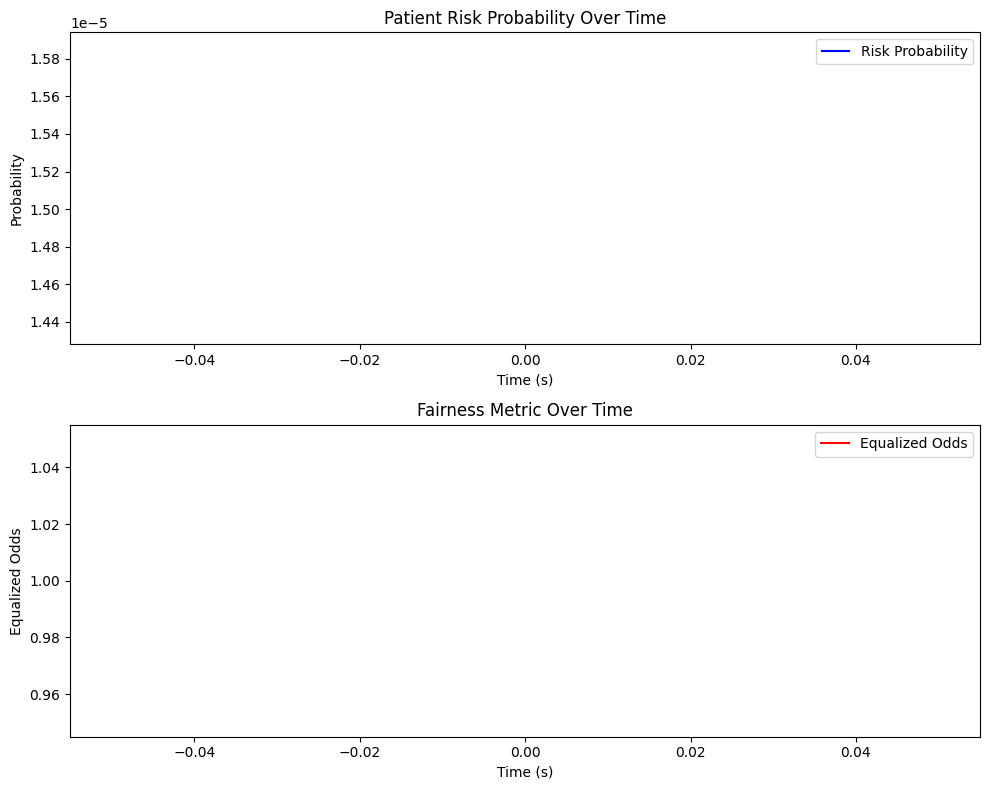

<Figure size 640x480 with 0 Axes>

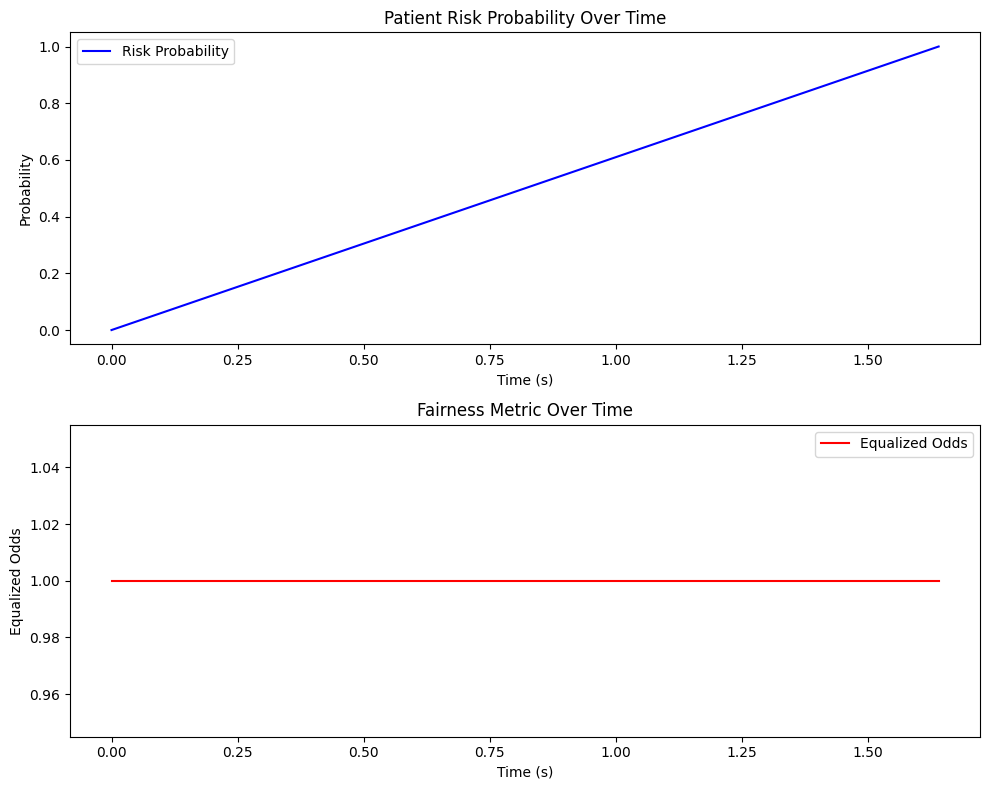

<Figure size 640x480 with 0 Axes>

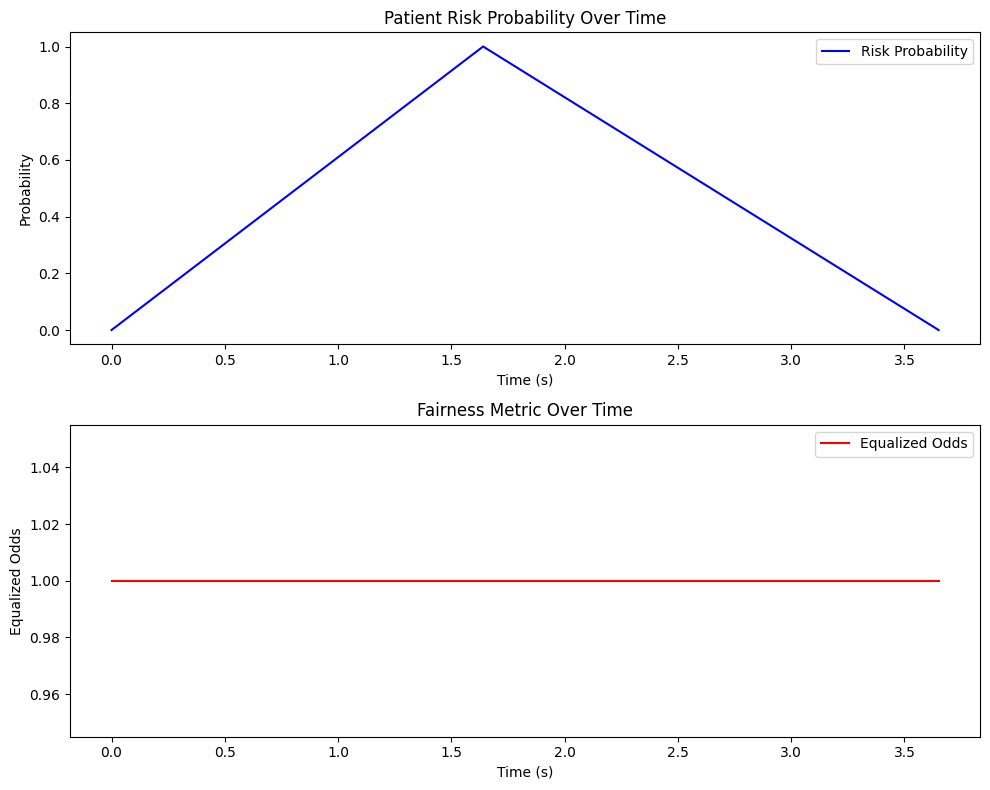

<Figure size 640x480 with 0 Axes>

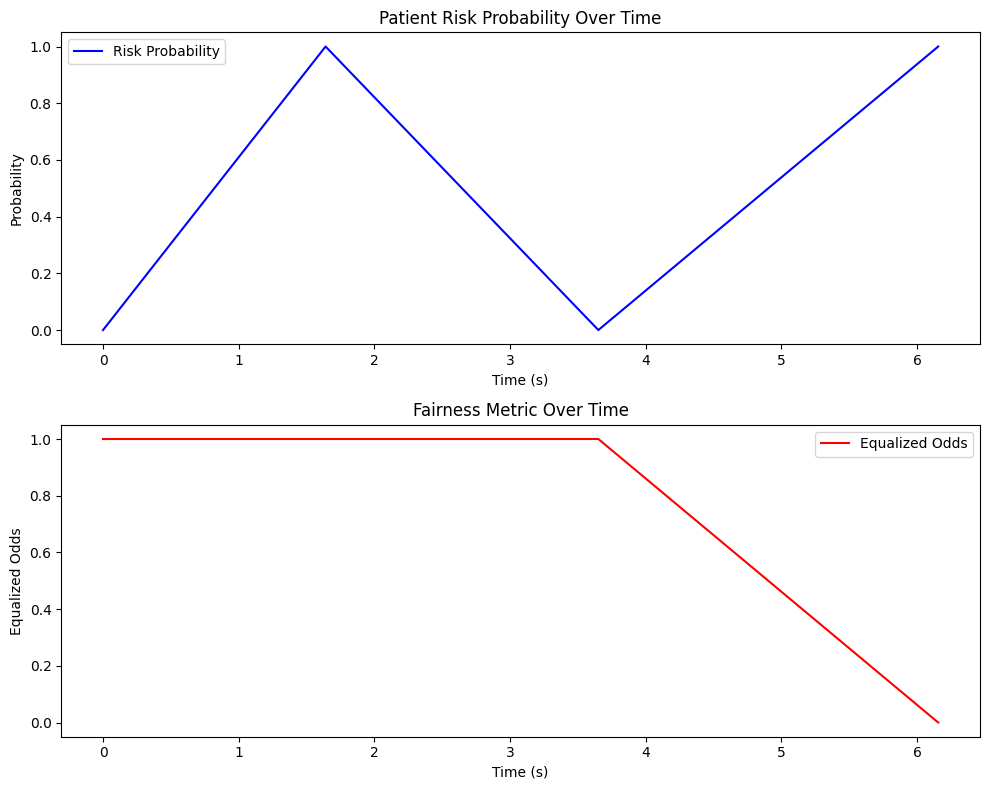

<Figure size 640x480 with 0 Axes>

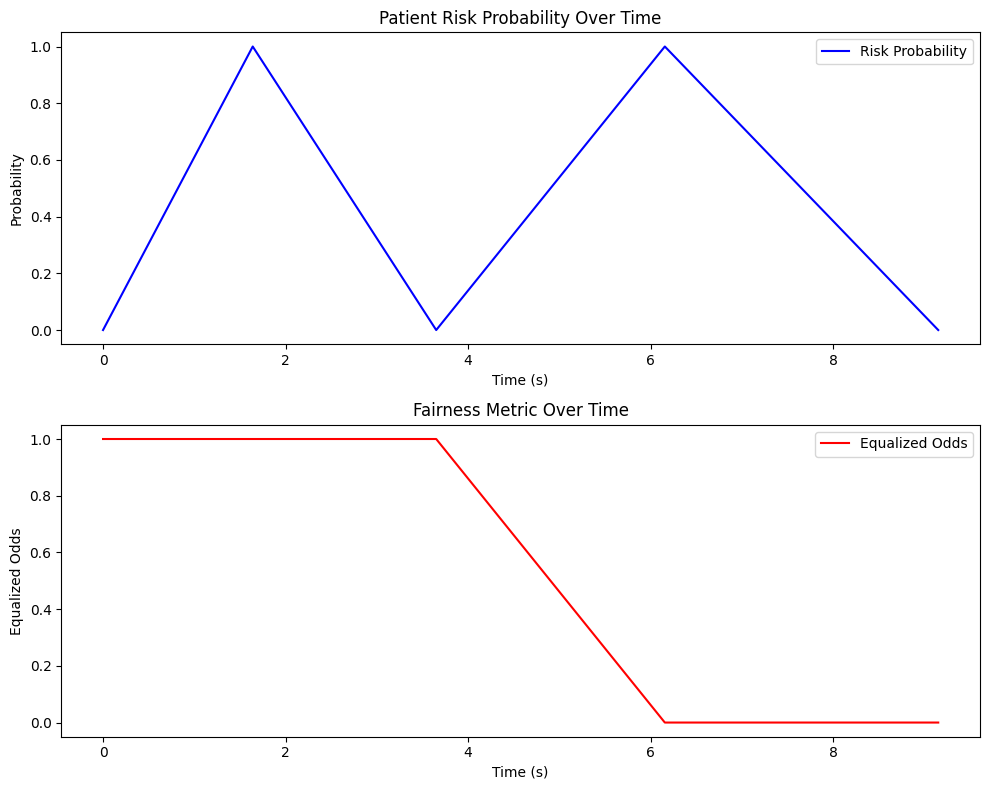

<Figure size 640x480 with 0 Axes>

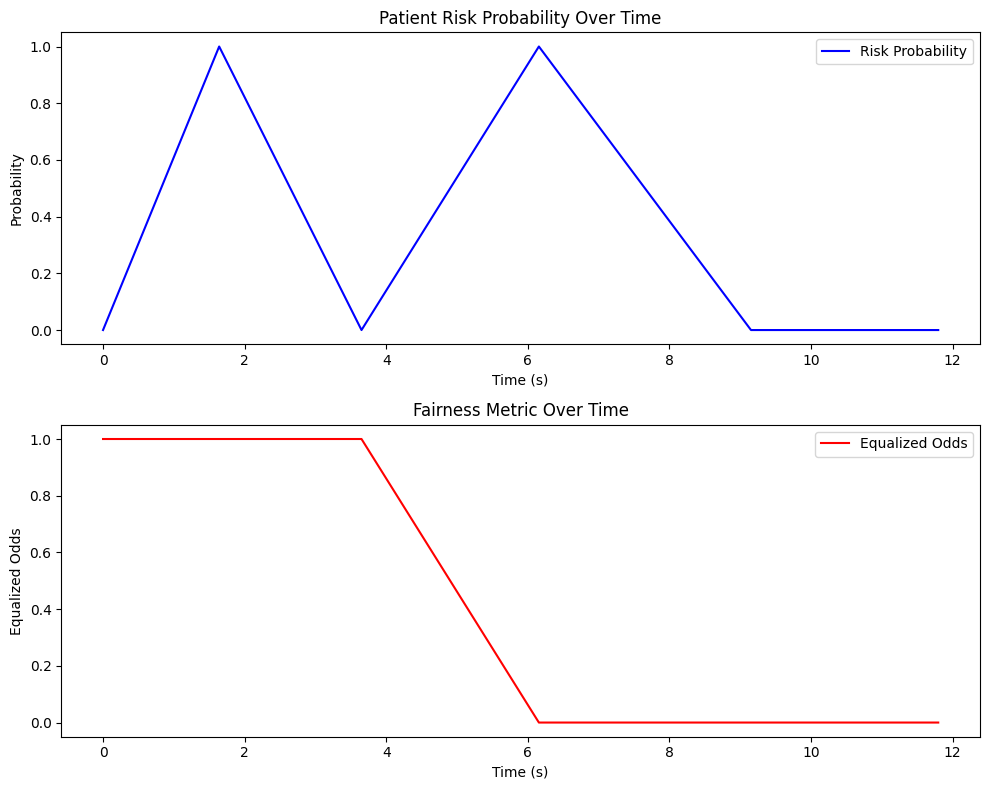

<Figure size 640x480 with 0 Axes>

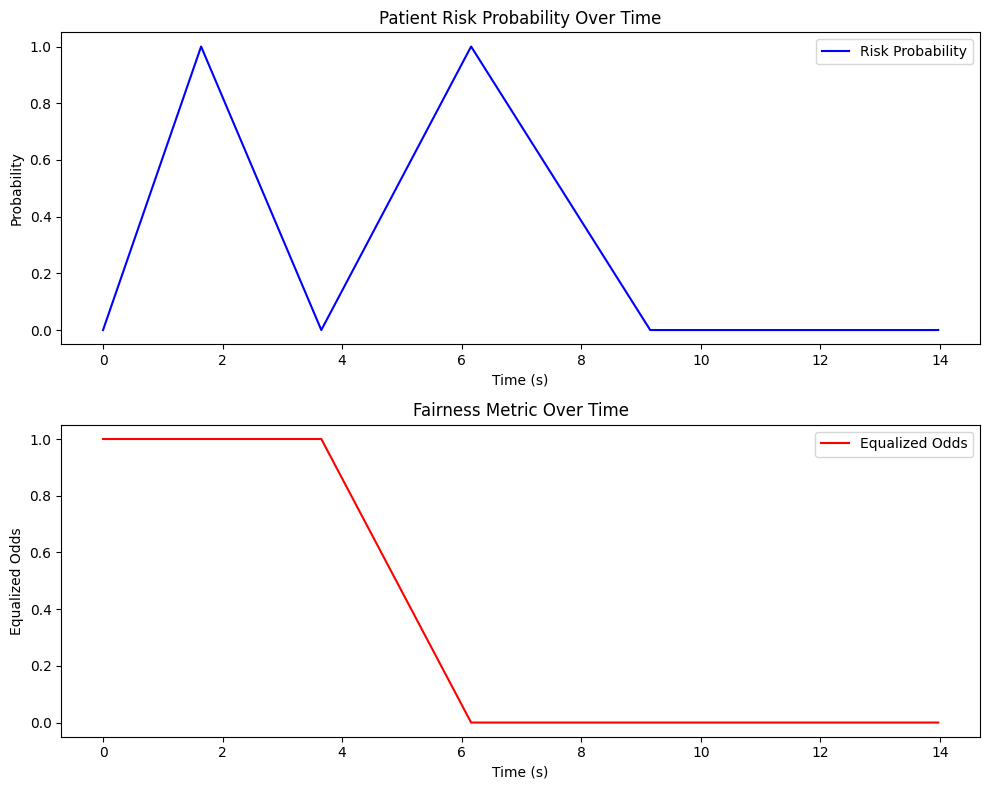

<Figure size 640x480 with 0 Axes>

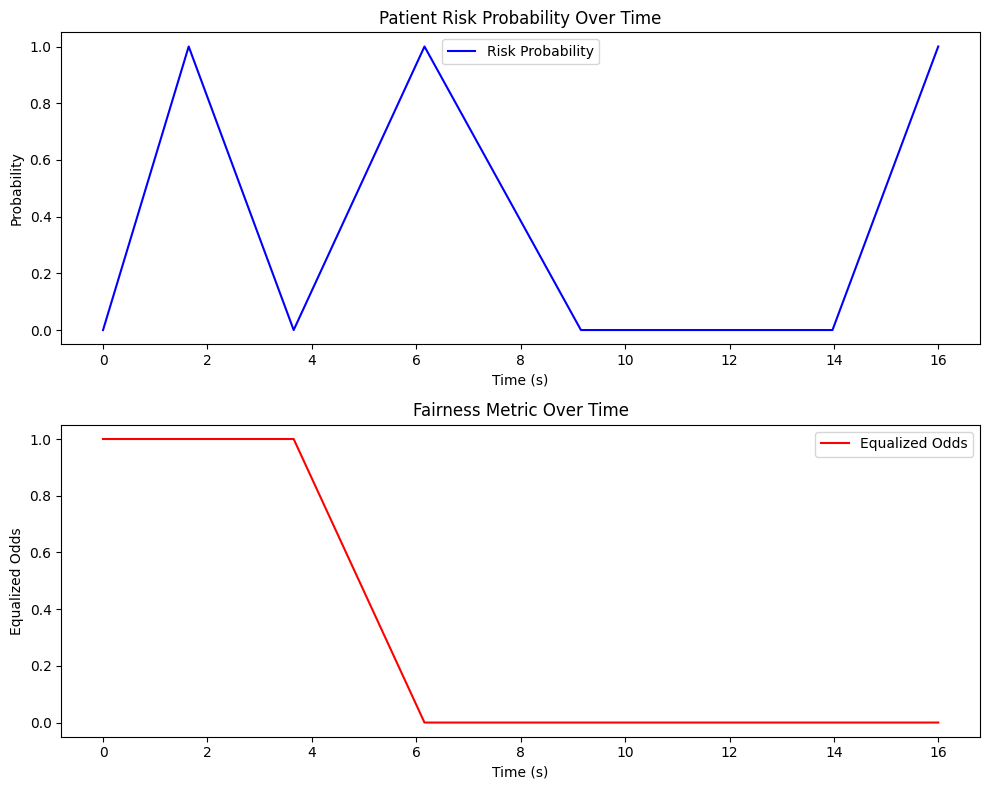

<Figure size 640x480 with 0 Axes>

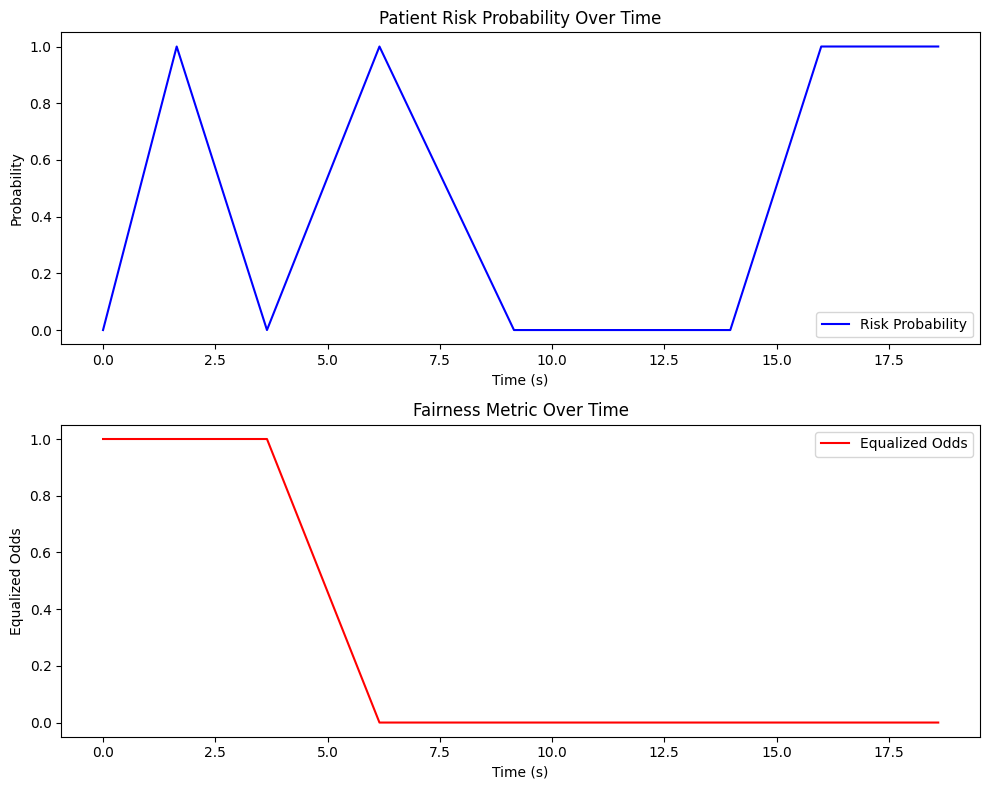

<Figure size 640x480 with 0 Axes>

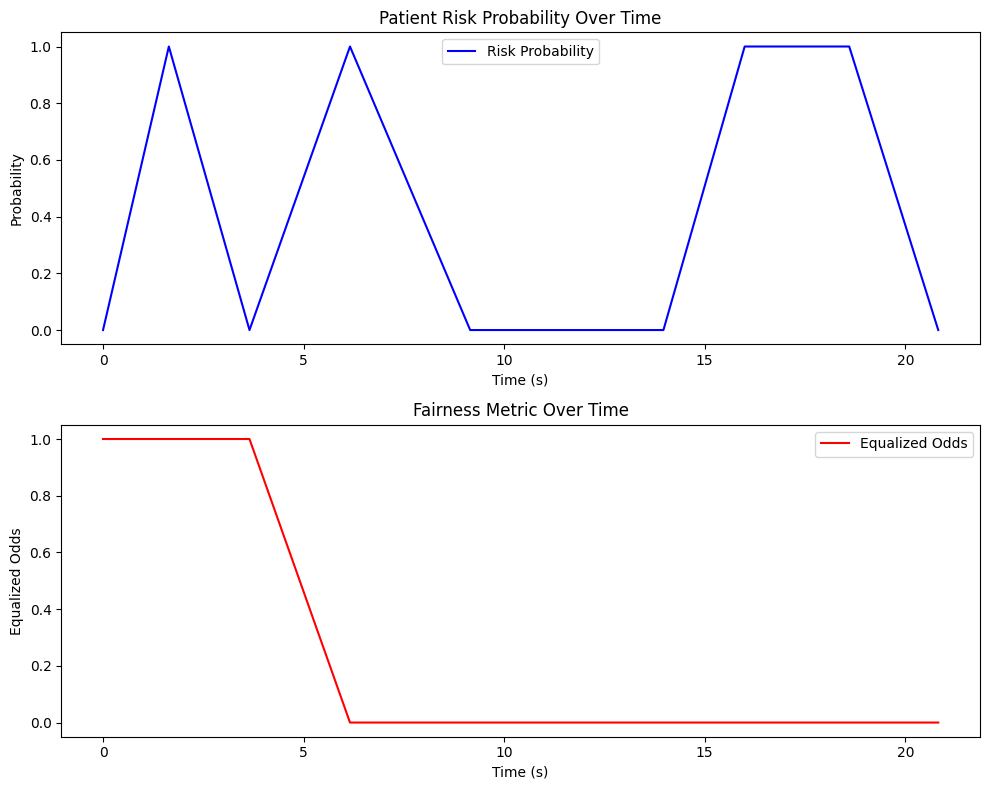

<Figure size 640x480 with 0 Axes>

In [ ]:
# Import libraries and set up for Colab
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from collections import deque
import time
import matplotlib.pyplot as plt
import logging
from IPython.display import Image, display, clear_output

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

# Enable inline plotting in Colab
%matplotlib inline

class FairPulse:
    def __init__(self, window_size=50):
        self.model = GradientBoostingClassifier(n_estimators=100, random_state=42)
        self.scaler = StandardScaler()
        self.window = deque(maxlen=window_size)
        self.fairness_weights = None
        self.is_trained = False
        self.feature_names = ['heart_rate', 'blood_pressure', 'oxygen_level', 'age', 'gender', 'race']
        self.history = []

    def generate_synthetic_data(self, n_samples=1, training=False):
        np.random.seed(int(time.time()) if not training else 42)
        data = {
            'heart_rate': np.random.normal(80, 15, n_samples),
            'blood_pressure': np.random.normal(120, 20, n_samples),
            'oxygen_level': np.random.normal(95, 5, n_samples),
            'age': np.random.normal(50, 15, n_samples),
            'gender': np.random.binomial(1, 0.5, n_samples),
            'race': np.random.binomial(1, 0.6, n_samples),
        }
        X = pd.DataFrame(data)
        y = ((X['heart_rate'] > 100) | (X['blood_pressure'] > 140) |
             (X['oxygen_level'] < 90)).astype(int)
        return X, y

    def preprocess_stream(self, X_new, y_new=None):
        X_scaled = self.scaler.transform(X_new)
        if y_new is not None and not self.is_trained:
            self.fairness_weights = np.where(X_new['gender'] == 0, 1.2, 1.0)
        return X_scaled

    def update_fairness_metrics(self, X, y_true, y_pred):
        self.window.append((X, y_true, y_pred))
        if len(self.window) < 2:
            return {"equalized_odds": 1.0}

        window_data = list(zip(*self.window))
        X_window, y_true_window, y_pred_window = pd.concat(window_data[0]), \
                                                 np.concatenate(window_data[1]), \
                                                 np.concatenate(window_data[2])

        male_mask = (X_window['gender'] == 1) & (y_true_window == 1)
        female_mask = (X_window['gender'] == 0) & (y_true_window == 1)

        tpr_male = np.mean(y_pred_window[male_mask]) if male_mask.any() else 0.0
        tpr_female = np.mean(y_pred_window[female_mask]) if female_mask.any() else 0.0

        equalized_odds = 1 - abs(tpr_male - tpr_female) if not np.isnan(tpr_male - tpr_female) else 1.0
        return {"equalized_odds": equalized_odds}

    def predict_with_intervention(self, X_new):
        X_scaled = self.preprocess_stream(X_new)
        probs = self.model.predict_proba(X_scaled)[:, 1]
        preds = (probs > 0.5).astype(int)
        uncertainty = -(probs * np.log(probs + 1e-10)).sum()
        if self.fairness_weights is not None and len(self.fairness_weights) == len(probs):
            probs *= self.fairness_weights
        intervention = "Monitor closely" if uncertainty > 0.5 or probs[0] > 0.7 else "Standard care"
        return preds[0], probs[0], intervention

    def train_initial(self):
        X_train, y_train = self.generate_synthetic_data(n_samples=200, training=True)
        X_scaled = self.scaler.fit_transform(X_train)
        self.fairness_weights = np.where(X_train['gender'] == 0, 1.2, 1.0)
        self.model.fit(X_scaled, y_train)
        self.is_trained = True
        logging.info("Model trained with initial data.")

    def run_simulation_with_viz(self, interval=1, max_iterations=10):
        """Run simulation with inline visualization for Colab."""
        logging.info("Starting simulation with inline visualization...")

        for i in range(max_iterations):
            X_new, y_true = self.generate_synthetic_data(n_samples=1)
            pred, prob, intervention = self.predict_with_intervention(X_new)

            logging.info(f"Iteration {i+1}/{max_iterations}")
            logging.info(f"Patient Data: {X_new.iloc[0].to_dict()}")
            logging.info(f"Prediction: {pred}, Probability: {prob:.3f}, Intervention: {intervention}")

            fairness = self.update_fairness_metrics(X_new, y_true, np.array([pred]))
            logging.info(f"Fairness (Equalized Odds): {fairness['equalized_odds']:.3f}")

            self.history.append({
                'time': time.time(),
                'prob': prob,
                'fairness': fairness['equalized_odds']
            })

            times = [h['time'] - self.history[0]['time'] for h in self.history]
            probs = [h['prob'] for h in self.history]
            fairness_vals = [h['fairness'] for h in self.history]

            # Create and display plot
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

            ax1.plot(times, probs, 'b-', label='Risk Probability')
            ax1.set_title("Patient Risk Probability Over Time")
            ax1.set_xlabel("Time (s)")
            ax1.set_ylabel("Probability")
            ax1.legend()

            ax2.plot(times, fairness_vals, 'r-', label='Equalized Odds')
            ax2.set_title("Fairness Metric Over Time")
            ax2.set_xlabel("Time (s)")
            ax2.set_ylabel("Equalized Odds")
            ax2.legend()

            plt.tight_layout()
            plt.show()  # Display inline in Colab

            # Save to file (optional, for reference)
            plt.savefig(f'plot_iteration_{i+1}.png')
            logging.info(f"Saved plot to plot_iteration_{i+1}.png")

            # Simulate delay and clear output to avoid clutter
            time.sleep(interval)


        logging.info("Simulation complete.")

def main():
    fairpulse = FairPulse()
    fairpulse.train_initial()
    fairpulse.run_simulation_with_viz(interval=1, max_iterations=10)

if __name__ == "__main__":
    main()